# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

##### _Authored By_
- Rajiv Gaba
- Rajeev Srikanth

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [89]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [90]:
# Define a function to load data and aggregate them

def load_and_aggregate_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    return df


In [91]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

amzn_file = '/Users/RajivGaba/aiml_projects/RNN_Assignment/RNN_Stocks_Data/AMZN_stocks_data.csv'
goog_file = '/Users/RajivGaba/aiml_projects/RNN_Assignment/RNN_Stocks_Data/GOOGL_stocks_data.csv'
msft_file = '/Users/RajivGaba/aiml_projects/RNN_Assignment/RNN_Stocks_Data/MSFT_stocks_data.csv'
ibm_file = '/Users/RajivGaba/aiml_projects/RNN_Assignment/RNN_Stocks_Data/IBM_stocks_data.csv'

amzn_df = load_and_aggregate_data(amzn_file)
goog_df = load_and_aggregate_data(goog_file)
msft_df = load_and_aggregate_data(msft_file)
ibm_df = load_and_aggregate_data(ibm_file)

df_list = [amzn_df, goog_df, msft_df, ibm_df]

# Concatenate the dataframes
stocks_df = pd.concat([amzn_df, goog_df, msft_df, ibm_df], ignore_index=True)


In [92]:
# View specifics of the data

stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [93]:
# Handle Missing Values

stocks_df.dropna(inplace=True)
stocks_df.reset_index(drop=True, inplace=True)
stocks_df.info()

for i, f in enumerate(df_list):
    print(f"DataFrame {i} has {f.isnull().sum().sum()} missing values.")

ibm_df.dropna(inplace=True)
ibm_df.reset_index(drop=True, inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12076 entries, 0 to 12075
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12076 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12076 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12076 non-null  float64
 5   Volume  12076 non-null  int64  
 6   Name    12076 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.5+ KB
DataFrame 0 has 0 missing values.
DataFrame 1 has 0 missing values.
DataFrame 2 has 0 missing values.
DataFrame 3 has 2 missing values.


In [94]:
ibm_df.head(), ibm_df.tail()

(         Date   Open   High    Low  Close    Volume Name
 0  2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM
 1  2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM
 2  2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM
 3  2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM
 4  2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM,
             Date    Open    High     Low   Close   Volume Name
 3014  2017-12-22  151.82  153.00  151.50  152.50  2990583  IBM
 3015  2017-12-26  152.51  153.86  152.50  152.83  2479017  IBM
 3016  2017-12-27  152.95  153.18  152.61  153.13  2149257  IBM
 3017  2017-12-28  153.20  154.12  153.20  154.04  2687624  IBM
 3018  2017-12-29  154.17  154.72  153.42  153.42  3327087  IBM)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

<Figure size 1000x600 with 0 Axes>

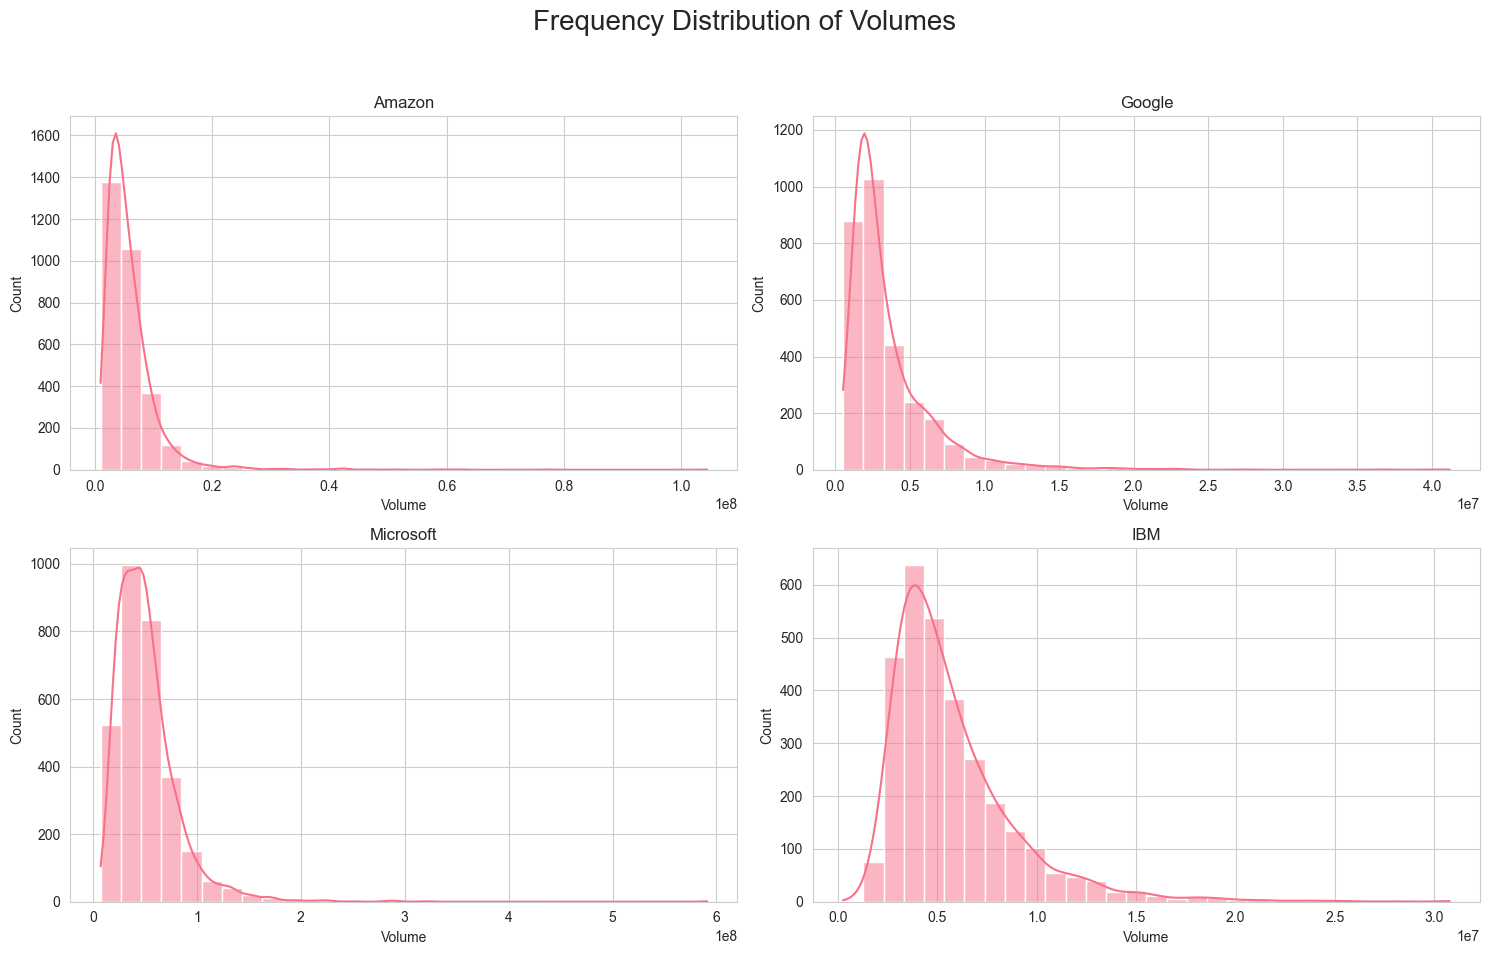

In [95]:
# Frequency distribution of volumes

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('husl')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Frequency Distribution of Volumes', fontsize=20)
sns.histplot(data=amzn_df, x='Volume', bins=30, kde=True, ax=axes[0, 0])
sns.histplot(data=goog_df, x='Volume', bins=30, kde=True, ax=axes[0, 1])
sns.histplot(data=msft_df, x='Volume', bins=30, kde=True, ax=axes[1, 0])
sns.histplot(data=ibm_df, x='Volume', bins=30, kde=True, ax=axes[1, 1])
axes[0, 0].set_title('Amazon')
axes[0, 1].set_title('Google')
axes[1, 0].set_title('Microsoft')
axes[1, 1].set_title('IBM')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



<Figure size 1000x600 with 0 Axes>

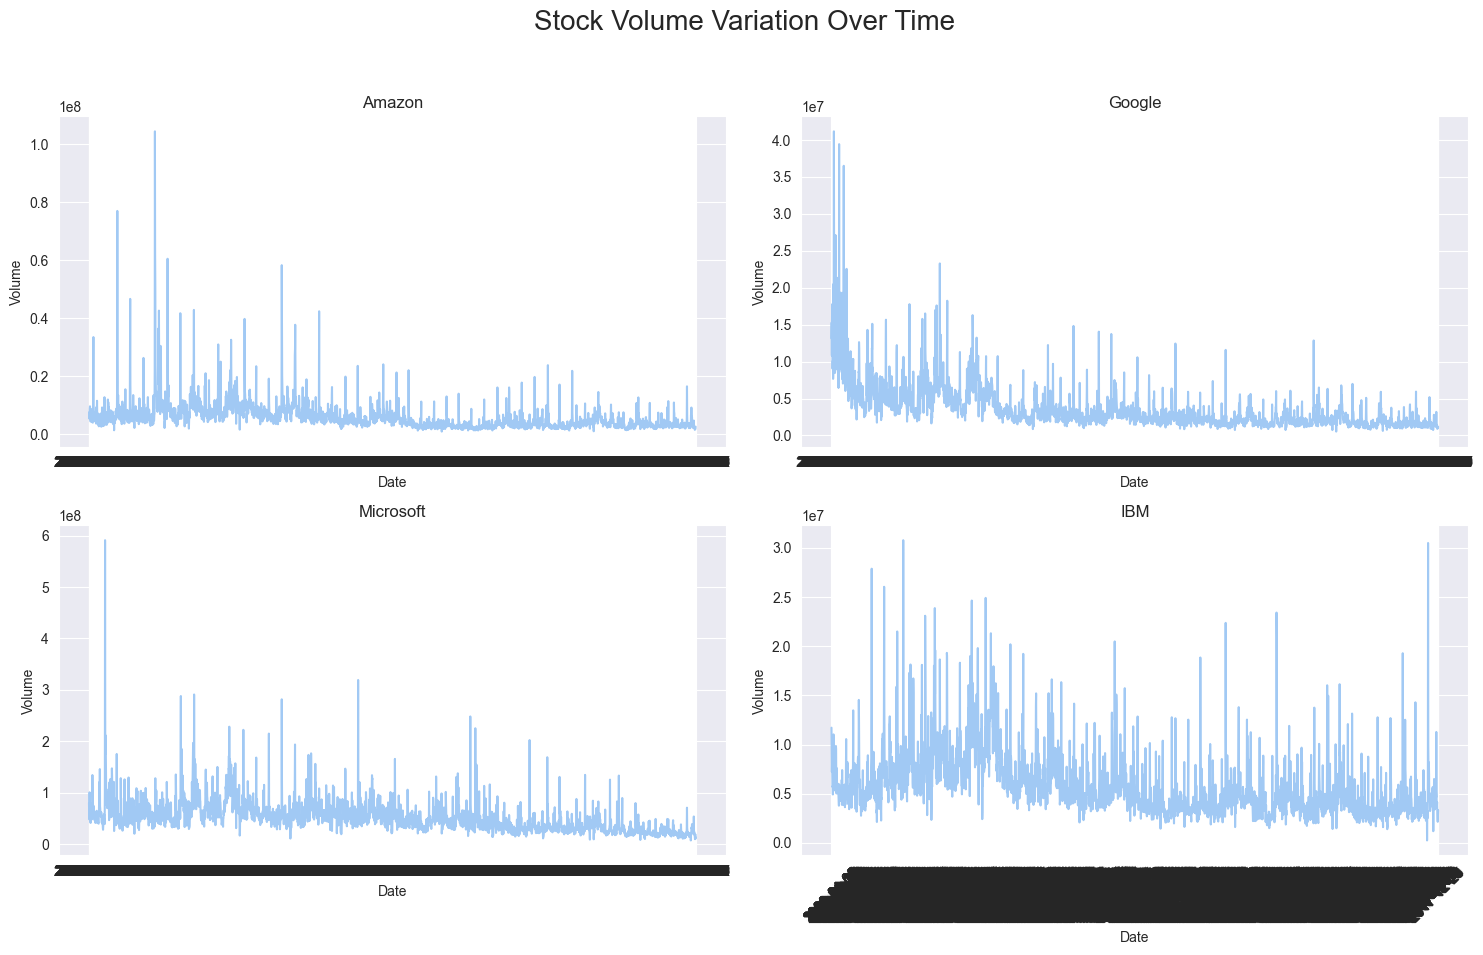

In [96]:
# Stock volume variation over time

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Volume Variation Over Time', fontsize=20)
sns.lineplot(data=amzn_df, x='Date', y='Volume', ax=axes[0, 0])
sns.lineplot(data=goog_df, x='Date', y='Volume', ax=axes[0, 1])
sns.lineplot(data=msft_df, x='Date', y='Volume', ax=axes[1, 0])
sns.lineplot(data=ibm_df, x='Date', y='Volume', ax=axes[1, 1])
axes[0, 0].set_title('Amazon')
axes[0, 1].set_title('Google')
axes[1, 0].set_title('Microsoft')
axes[1, 1].set_title('IBM')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

<Figure size 800x400 with 0 Axes>

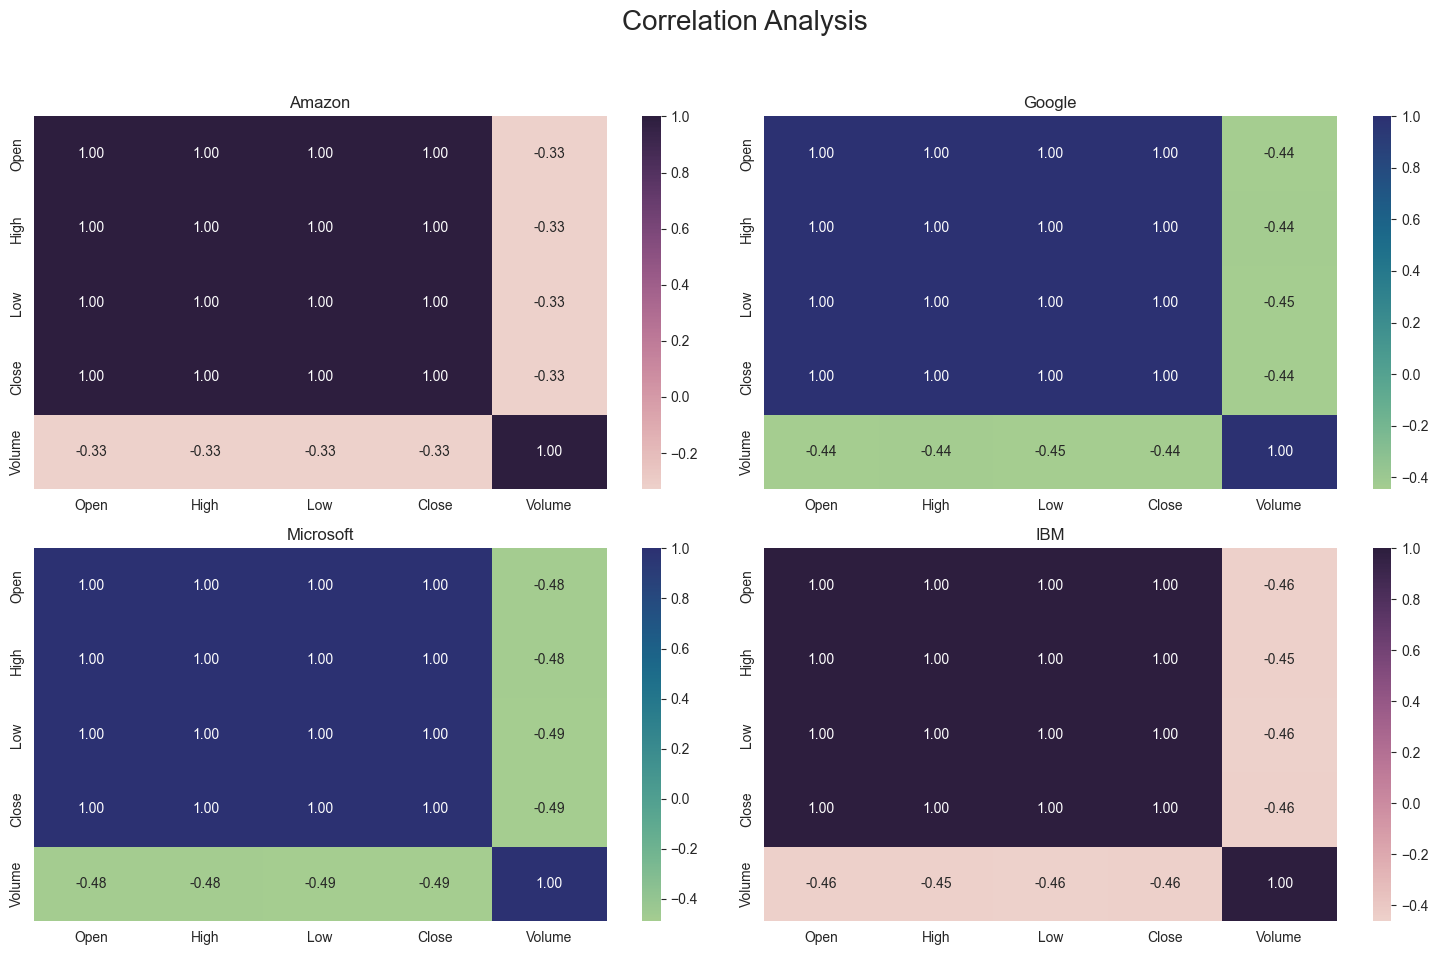

In [97]:
# Analyse correlations

corr_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(8, 4))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Correlation Analysis', fontsize=20)
sns.heatmap(amzn_df[corr_cols].corr(), annot=True, fmt='.2f', cmap=sns.cubehelix_palette(as_cmap=True), ax=axes[0, 0])
sns.heatmap(goog_df[corr_cols].corr(), annot=True, fmt='.2f', cmap="crest", ax=axes[0, 1])
sns.heatmap(msft_df[corr_cols].corr(), annot=True, fmt='.2f', cmap="crest", ax=axes[1, 0])
sns.heatmap(ibm_df[corr_cols].corr(), annot=True, fmt='.2f', cmap=sns.cubehelix_palette(as_cmap=True), ax=axes[1, 1])
axes[0, 0].set_title('Amazon')
axes[0, 1].set_title('Google')
axes[1, 0].set_title('Microsoft')
axes[1, 1].set_title('IBM')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [98]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windows(data, window_size=5):
    """
    Create windows of data for time series forecasting.
    
    Parameters:
    - data: DataFrame containing the stock data.
    - window_size: Size of the window to create.
    
    Returns:
    - X: Features (windows of data).
    - y: Target variable (next value after each window).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size].values)
        y.append(data.iloc[i + window_size]['Close'])
    return np.array(X), np.array(y)



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [99]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windows(X, y):
    """
    Scale the windowed data using MinMaxScaler.
    
    Parameters:
    - X: Features (windows of data).
    - y: Target variable (next value after each window).
    
    Returns:
    - X_scaled: Scaled features.
    - y_scaled: Scaled target variable.
    """
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1))
    return X_scaled, y_scaled



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [100]:
# Define a function to create input and output data points from the master DataFrame
def create_input_output_data(df, window_size=5):
    """
    Create input and output data points from the master DataFrame.
    
    Parameters:
    - df: DataFrame containing the stock data.
    - window_size: Size of the window to create.
    
    Returns:
    - X: Features (windows of data).
    - y: Target variable (next value after each window).
    """
    # Create windows
    X, y = create_windows(df, window_size)
    
    # Scale windows
    X_scaled, y_scaled = scale_windows(X, y)
    
    return X_scaled, y_scaled



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

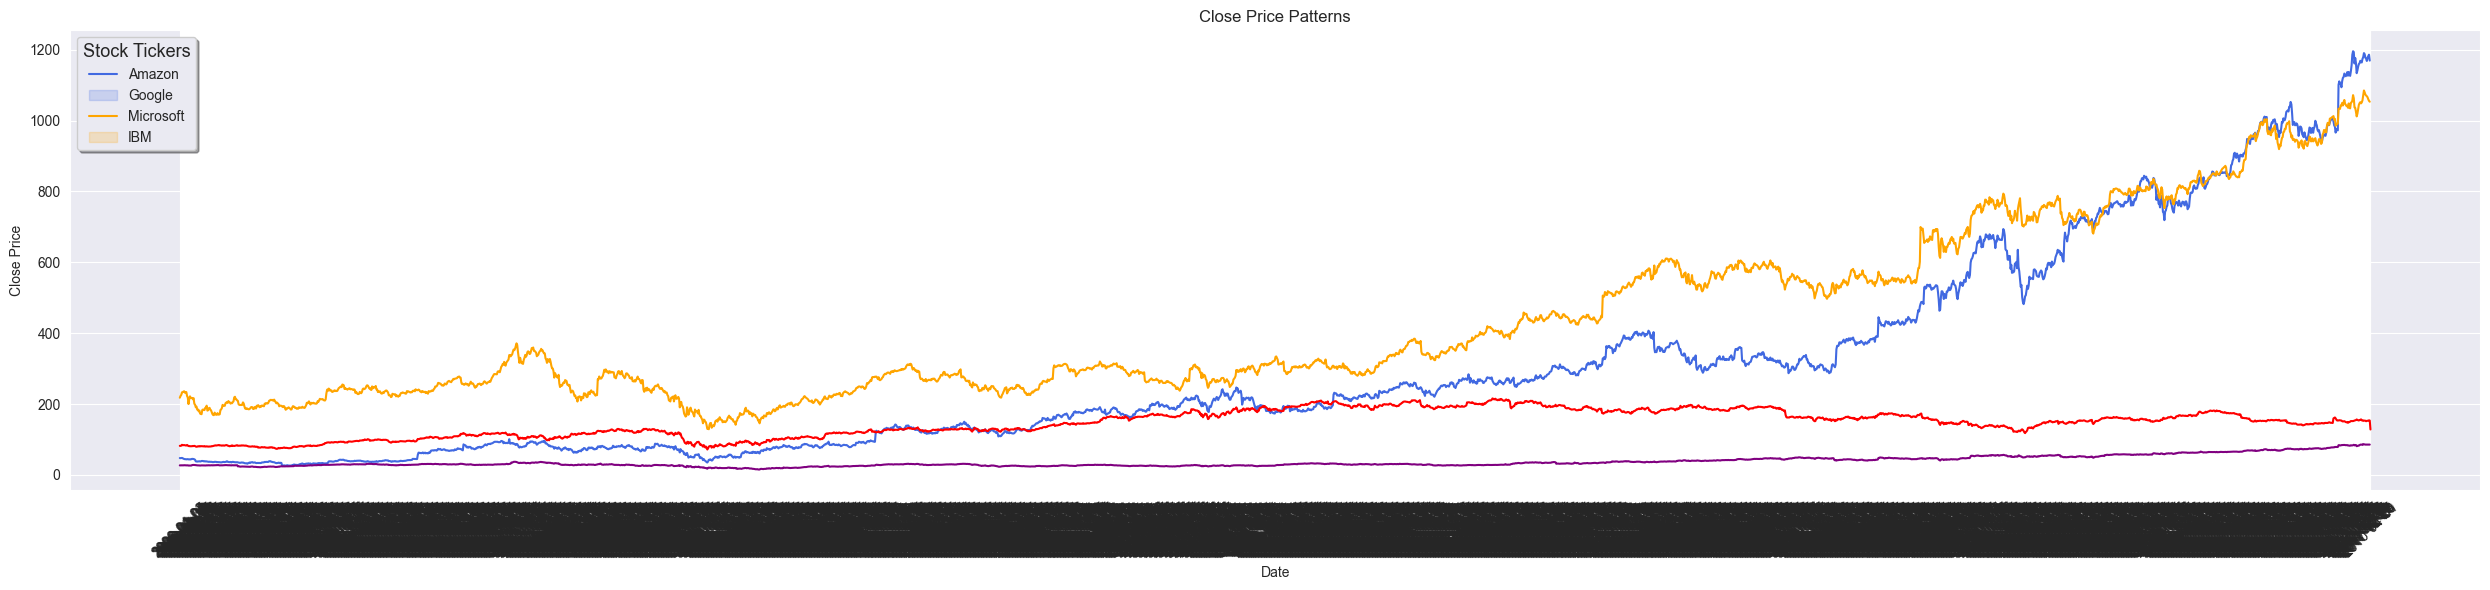

In [101]:
# Checking for patterns in different sequence lengths

plt.figure(figsize=(25, 6))
sns.lineplot(data=amzn_df, x='Date', y='Close', label='Close Price', color='royalblue')
sns.lineplot(data=goog_df, x='Date', y='Close', label='Close Price', color='orange')
sns.lineplot(data=msft_df, x='Date', y='Close', label='Close Price', color='purple')
sns.lineplot(data=ibm_df, x='Date', y='Close', label='Close Price', color='red')
plt.title('Close Price Patterns')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(['Amazon', 'Google', 'Microsoft', 'IBM'], loc='upper left', fontsize='medium', title='Stock Tickers', title_fontsize='13', shadow=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [102]:
# set the date column as index and drop name column
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)
amzn_df.sort_index(inplace=True)
amzn_df.drop(columns=['Name'], inplace=True)

goog_df['Date'] = pd.to_datetime(goog_df['Date'])
goog_df.set_index('Date', inplace=True)
goog_df.sort_index(inplace=True)
goog_df.drop(columns=['Name'], inplace=True)

msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df.set_index('Date', inplace=True)
msft_df.sort_index(inplace=True)
msft_df.drop(columns=['Name'], inplace=True)

ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
ibm_df.set_index('Date', inplace=True)
ibm_df.sort_index(inplace=True)
ibm_df.drop(columns=['Name'], inplace=True)



In [103]:
# Create data instances from the master data frame using decided window size and window stride

window_size = 7


amzn_X, amzn_y = create_input_output_data(amzn_df, window_size)
# goog_X, goog_y = create_input_output_data(goog_df, window_size)
# msft_X, msft_y = create_input_output_data(msft_df, window_size)
# ibm_X, ibm_y = create_input_output_data(ibm_df, window_size)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(amzn_X, amzn_y, test_size=0.2, random_state=42)

# split the data into training and testing sets using first 75% of the data for training and the rest for testing
amzn_train_size = int(len(amzn_X) * 0.70)
X_train, X_test = amzn_X[:amzn_train_size], amzn_X[amzn_train_size:]
y_train, y_test = amzn_y[:amzn_train_size], amzn_y[amzn_train_size:]


In [104]:
# Check the number of data points generated
print(f"Number of data points generated: {len(amzn_X)}")
print(f"Number of training data points: {len(X_train)}")
print(f"Number of testing data points: {len(X_test)}")
print(f"Number of features: {X_train.shape[2]}")

Number of data points generated: 3012
Number of training data points: 2108
Number of testing data points: 904
Number of features: 5


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [105]:
# Check if the datasets are compatible inputs to neural networks

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (2108, 7, 5)
y_train shape: (2108, 1)
X_test shape: (904, 7, 5)
y_test shape: (904, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [106]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_rnn_model(input_shape, units=50, activation='relu', dropout_rate=0.2):
    """
    Create a simple RNN model.
    
    Parameters:
    - input_shape: Shape of the input data.
    - units: Number of units in the RNN layer.
    - activation: Activation function for the RNN layer.
    - dropout_rate: Dropout rate for regularization.
    
    Returns:
    - model: Compiled RNN model.
    """

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape','r2_score'])
    
    return model



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [107]:
# Find an optimal configuration of simple RNN

def find_optimal_rnn_configuration(X_train, y_train, X_test, y_test, units_list, activation_list, dropout_rate_list):
    best_model = None
    best_mse = float('inf')
    best_rmse = float('inf')
    metric_dict = {}
    
    for units in units_list:
        for activation in activation_list:
            for dropout_rate in dropout_rate_list:
                print("="*100)
                print(f"Testing configuration: units={units}, activation={activation}, dropout_rate={dropout_rate}")
                
                # Create the model
                model = create_rnn_model((X_train.shape[1], X_train.shape[2]), units, activation, dropout_rate)
                
                # Train the model
                model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
                
                # Evaluate the model
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                print(f"MSE: {mse}")
                print(f"RMSE: {rmse}")
                print(f"MAE: {mae}")
                print(f"R2 Score: {r2}")
                
                # Check if this is the best model so far
                # if mse < best_mse:
                    # best_mse = mse
                    # best_model = model

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                
                # dictionary containing metrics
                metrics = {
                    'units': units,
                    'activation': activation,
                    'dropout_rate': dropout_rate,
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2_score': r2
                }

                metric_dict[f"{units}_{activation}_{dropout_rate}"] = metrics
    
    return best_model, metric_dict



In [108]:
# Find the best configuration based on evaluation metrics

units_list = [50, 100, 150]
activation_list = ['relu', 'tanh']
dropout_rate_list = [0.2, 0.3]
best_model, metric_dict = find_optimal_rnn_configuration(X_train, y_train, X_test, y_test, units_list, activation_list, dropout_rate_list)
print("-"*100)
print(f"Best model configuration: units={best_model.layers[0].units}, activation={best_model.layers[0].activation.__name__}, dropout_rate={best_model.layers[1].rate}")
print("-"*100)



Testing configuration: units=50, activation=relu, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 0.004099006299172956
RMSE: 0.0640234824042941
MAE: 0.05573496256892185
R2 Score: 0.911896129246358
Testing configuration: units=50, activation=relu, dropout_rate=0.3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 0.0002426803880133816
RMSE: 0.015578202335744057
MAE: 0.01155919395629321
R2 Score: 0.9947838378427746
Testing configuration: units=50, activation=tanh, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 0.00012514760061162688
RMSE: 0.01118693884007716
MAE: 0.007508716476023284
R2 Score: 0.9973100826823224
Testing configuration: units=50, activation=tanh, dropout_rate=0.3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 0.0014505263246074158
RMSE: 0.038085775882964704
MAE: 0.02747355565933354
R2 Score: 0.968822447563998
Testing configuration: units=100, activation=relu, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 0.00041111641623881555
RMSE: 0.

In [109]:
# convert metrics into dataframe

rnn_metrics_df = pd.DataFrame.from_dict(metric_dict, orient='index')
rnn_metrics_df.sort_values(by='mae', ascending=True, inplace=True)

In [110]:
rnn_metrics_df.head()

,units,activation,dropout_rate,mse,rmse,mae,r2_score
100_relu_0.3,100,relu,0.3,0.000098,0.009883,0.006552,0.997900
150_tanh_0.2,150,tanh,0.2,0.000108,0.010372,0.007004,0.997688
150_relu_0.3,150,relu,0.3,0.000108,0.010374,0.007104,0.997687
150_tanh_0.3,150,tanh,0.3,0.000121,0.010994,0.007490,0.997402
50_tanh_0.2,50,tanh,0.2,0.000125,0.011187,0.007509,0.997310


<Figure size 1500x1000 with 0 Axes>

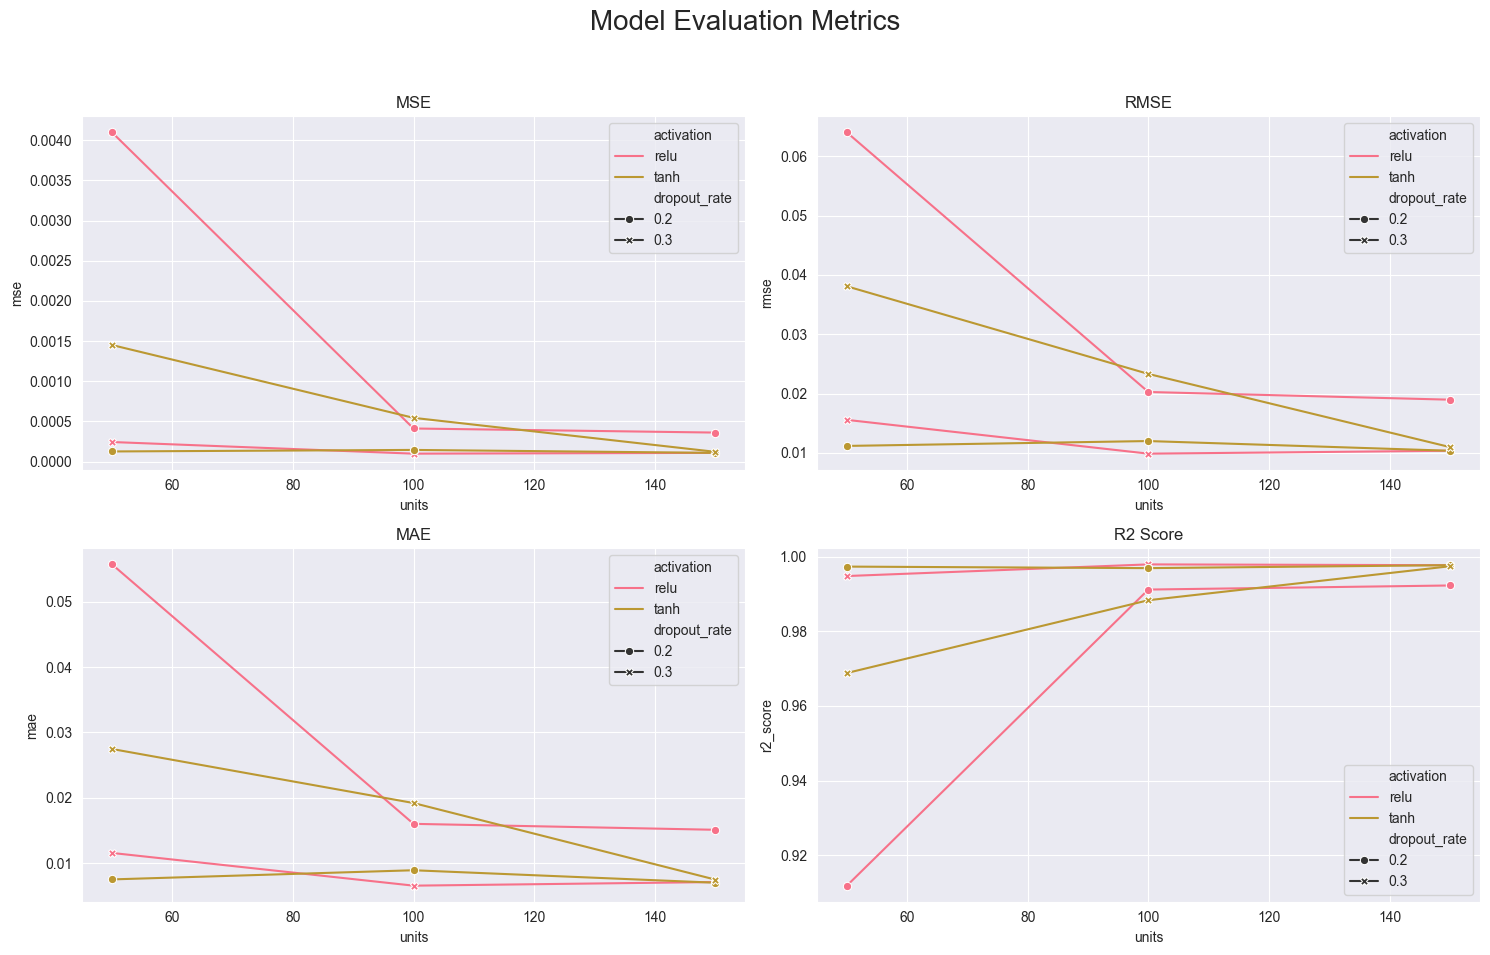

In [111]:
# plot the metrics from metric_df dataframe

plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
sns.set_palette('husl')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Evaluation Metrics', fontsize=20)
sns.lineplot(data=rnn_metrics_df, x='units', y='mse', hue='activation', style='dropout_rate', markers=True, dashes=False, ax=axes[0, 0])
sns.lineplot(data=rnn_metrics_df, x='units', y='rmse', hue='activation', style='dropout_rate', markers=True, dashes=False, ax=axes[0, 1])
sns.lineplot(data=rnn_metrics_df, x='units', y='mae', hue='activation', style='dropout_rate', markers=True, dashes=False, ax=axes[1, 0])
sns.lineplot(data=rnn_metrics_df, x='units', y='r2_score', hue='activation', style='dropout_rate', markers=True, dashes=False, ax=axes[1, 1])
axes[0, 0].set_title('MSE')
axes[0, 1].set_title('RMSE')
axes[1, 0].set_title('MAE')
axes[1, 1].set_title('R2 Score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [112]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


units = int(rnn_metrics_df.iloc[0][0])
activation = rnn_metrics_df.iloc[0][1]
dropout_rate = rnn_metrics_df.iloc[0][2]
batchsize = 32


srnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), units, activation, dropout_rate)
srnn_model.summary()
history = srnn_model.fit(X_train, y_train, epochs=50, batch_size=batchsize, validation_split=0.2, verbose=1)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_38 (SimpleRNN)       │ (None, 100)            │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,701 (41.80 KB)

 Trainable params: 10,701 (41.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3707e-04 - mae: 0.0199 - mape: 395.6702 - mse: 8.3707e-04 - r2_score: 0.7290 - val_loss: 3.8795e-04 - val_mae: 0.0184 - val_mape: 7.7729 - val_mse: 3.8795e-04 - val_r2_score: 0.7774
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5488e-04 - mae: 0.0109 - mape: 591.4066 - mse: 2.5488e-04 - r2_score: 0.9172 - val_loss: 1.7874e-04 - val_mae: 0.0119 - val_mape: 4.9558 - val_mse: 1.7874e-04 - val_r2_score: 0.8974
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0953e-04 - mae: 0.0095 - mape: 87.3593 - mse: 2.0953e-04 - r2_score: 0.9318 - val_loss: 6.3760e-05 - val_mae: 0.0063 - val_mape: 2.6332 - val_mse: 6.3760e-05 - val_r2_score: 0.9634
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3036e-04 - mae: 0.0079 - mape: 980.2609 - mse: 1.3036e-04 - r2_score: 0.9574 - val_loss: 5.0934e-05 - val_mae: 0.0054 - val_mape: 2.3555 - val_mse: 5.0934e-05 - val_r2_score: 0.9708
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━

Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


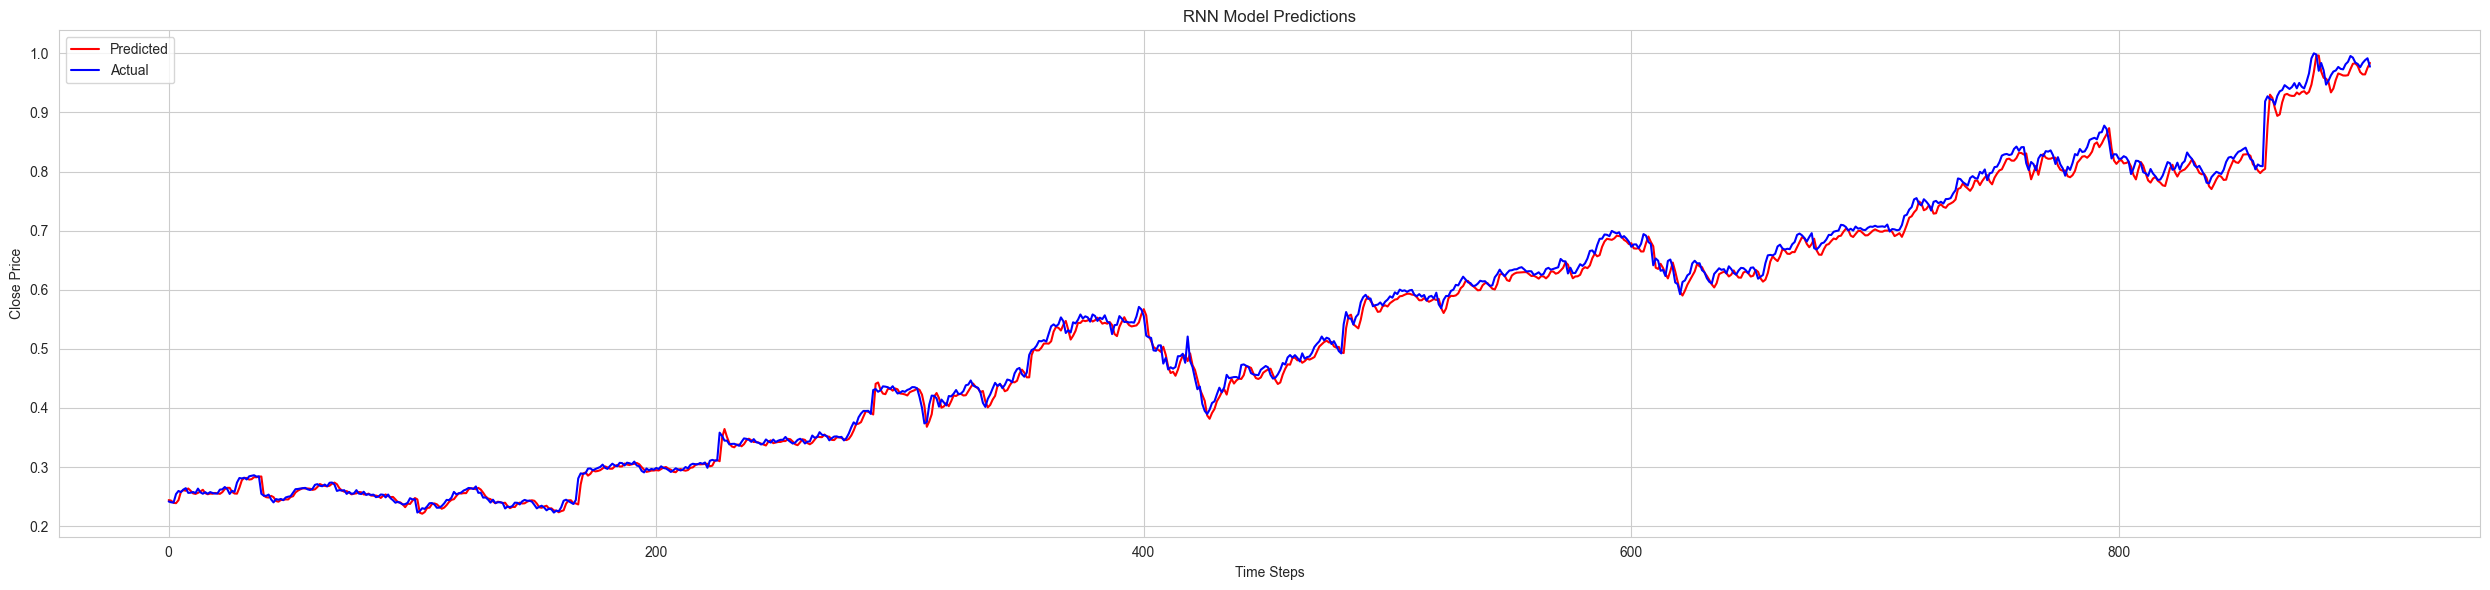

In [113]:
# Predict on the test data and plot

y_pred = srnn_model.predict(X_test)
plt.figure(figsize=(25, 6))
sns.set_style('whitegrid')
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred.ravel(), label='Predicted', markers=True, dashes=False, color='red')
sns.lineplot(x=np.arange(len(y_test)), y=y_test.ravel(), label='Actual', markers=True, dashes=False, color='blue')
plt.title('RNN Model Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()



In [114]:
predictions_df = pd.DataFrame(y_test, columns=['Actual'])
predictions_df['SRNN_Predicted'] = y_pred

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [115]:
# Compute the performance of the model on the testing data set

simple_rnn_mse = mean_squared_error(y_test, y_pred)
simple_rnn_rmse = np.sqrt(simple_rnn_mse)
simple_rnn_mae = mean_absolute_error(y_test, y_pred)
simple_rnn_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {simple_rnn_mse}")
print(f"Test RMSE: {simple_rnn_rmse}")
print(f"Test MAE: {simple_rnn_mae}")
print(f"Test R2 Score: {simple_rnn_r2}")



Test MSE: 0.00015864878527792006
Test RMSE: 0.0125955859442076
Test MAE: 0.009020693718065489
Test R2 Score: 0.9965900096137524


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [116]:
# # Define a function to create a model and specify default values for hyperparameters

def create_model(input_shape, units=50, activation='relu', dropout_rate=0.2, model_type='LSTM'):
    """
    Create a simple RNN model.
    
    Parameters:
    - input_shape: Shape of the input data.
    - units: Number of units in the RNN layer.
    - activation: Activation function for the RNN layer.
    - dropout_rate: Dropout rate for regularization.
    
    Returns:
    - model: Compiled RNN model.
    """
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    

    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation=activation, input_shape=input_shape))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation=activation, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units, activation=activation, input_shape=input_shape))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape', 'r2_score'])
    
    return model



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [117]:
# Find an optimal configuration
def find_optimal_arnn_configuration(X_train, y_train, X_test, y_test, units_list, activation_list, dropout_rate_list, batchsize_list, model_type='LSTM'):
    best_model = None
    best_mse = float('inf')
    best_rmse = float('inf')
    metric_dict = {}
    for units in units_list:
        for activation in activation_list:
            for dropout_rate in dropout_rate_list:
                for batchsize in batchsize_list:
                    print("="*100)
                    print(f"Testing configuration: units={units}, activation={activation}, dropout_rate={dropout_rate}")
                    
                    # Create the model
                    model = create_model((X_train.shape[1], X_train.shape[2]), units, activation, dropout_rate, model_type)
                    
                    # Train the model
                    model.fit(X_train, y_train, epochs=50, batch_size=batchsize, verbose=0, validation_split=0.2)
                    
                    # Evaluate the model
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)
                    print(f"MSE: {mse}")
                    print(f"RMSE: {rmse}")
                    print(f"MAE: {mae}")
                    print(f"R2 Score: {r2}")
                    
                    # Check if this is the best model so far
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = model
                    
                    # dictionary containing metrics
                    metrics = {
                        'units': units,
                        'activation': activation,
                        'dropout_rate': dropout_rate,
                        'mse': mse,
                        'rmse': rmse,
                        'mae': mae,
                        'r2_score': r2,
                        'batchsize': batchsize
                    }
                    metric_dict[f"{units}_{activation}_{dropout_rate}_{batchsize}"] = metrics
    return best_model, metric_dict



In [118]:
units_list = [50, 100, 150]
activation_list = ['relu', 'tanh']
dropout_rate_list = [0.2, 0.3]
batchsize_list = [32, 64, 128]
best_model, metric_dict = find_optimal_arnn_configuration(X_train, y_train, X_test, y_test, units_list, activation_list, dropout_rate_list, batchsize_list, model_type='LSTM')

print("-"*100)
print(f"Best model configuration: units={best_model.layers[0].units}, activation={best_model.layers[0].activation.__name__}, dropout_rate={best_model.layers[1].rate}")
print("-"*100)

Testing configuration: units=50, activation=relu, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.01662324013908033
RMSE: 0.1289311449537323
MAE: 0.0918177679088425
R2 Score: 0.6427007684726443
Testing configuration: units=50, activation=relu, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.061475359697730055
RMSE: 0.2479422507313549
MAE: 0.1625347699586887
R2 Score: -0.32134882213654414
Testing configuration: units=50, activation=relu, dropout_rate=0.2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.005463819982698286
RMSE: 0.07391765677223736
MAE: 0.05026812777518222
R2 Score: 0.882560880749575
Testing configuration: units=50, activation=relu, dropout_rate=0.3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.0008214162837082874
RMSE: 0.028660360843999984
MAE: 0.02142883865489777
R2 Score: 0.9823445125933635
Testing configuration: units=50, activation=relu, dropout_rate=0.3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.026936970231780558
RMSE: 0.16412486171138

In [119]:
# create a dataframe from the metrics dictionary
metrics_df = pd.DataFrame.from_dict(metric_dict, orient='index')
metrics_df.sort_values(by='mae', ascending=True, inplace=True)

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [120]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

units = int(metrics_df.iloc[0][0])
activation = metrics_df.iloc[0][1]
dropout_rate = metrics_df.iloc[0][2]
batchsize = int(metrics_df.iloc[0][7])


lstm_model = create_model((X_train.shape[1], X_train.shape[2]), units, activation, dropout_rate, model_type='LSTM')
lstm_model.summary()
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=batchsize, validation_split=0.2, verbose=1)



Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_73 (LSTM)                  │ (None, 150)            │        93,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,751 (366.21 KB)

 Trainable params: 93,751 (366.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - mae: 0.0443 - mape: 687.4158 - mse: 0.0038 - r2_score: -0.2269 - val_loss: 4.7305e-04 - val_mae: 0.0203 - val_mape: 8.8243 - val_mse: 4.7305e-04 - val_r2_score: 0.7286
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7321e-04 - mae: 0.0099 - mape: 601.1357 - mse: 1.7321e-04 - r2_score: 0.9441 - val_loss: 8.2879e-05 - val_mae: 0.0069 - val_mape: 3.0206 - val_mse: 8.2879e-05 - val_r2_score: 0.9524
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4653e-05 - mae: 0.0064 - mape: 728.3147 - mse: 8.4653e-05 - r2_score: 0.9725 - val_loss: 6.1660e-05 - val_mae: 0.0060 - val_mape: 2.5726 - val_mse: 6.1660e-05 - val_r2_score: 0.9646
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8381e-05 - mae: 0.0054 - mape: 301.0242 - mse: 5.8381e-05 - r2_score: 0.9810 - val_loss: 6.2385e-05 - val_mae: 0.0058 - val_mape: 2.5033 - val_mse: 6.2385e-05 - val_r2_score: 0.9642
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

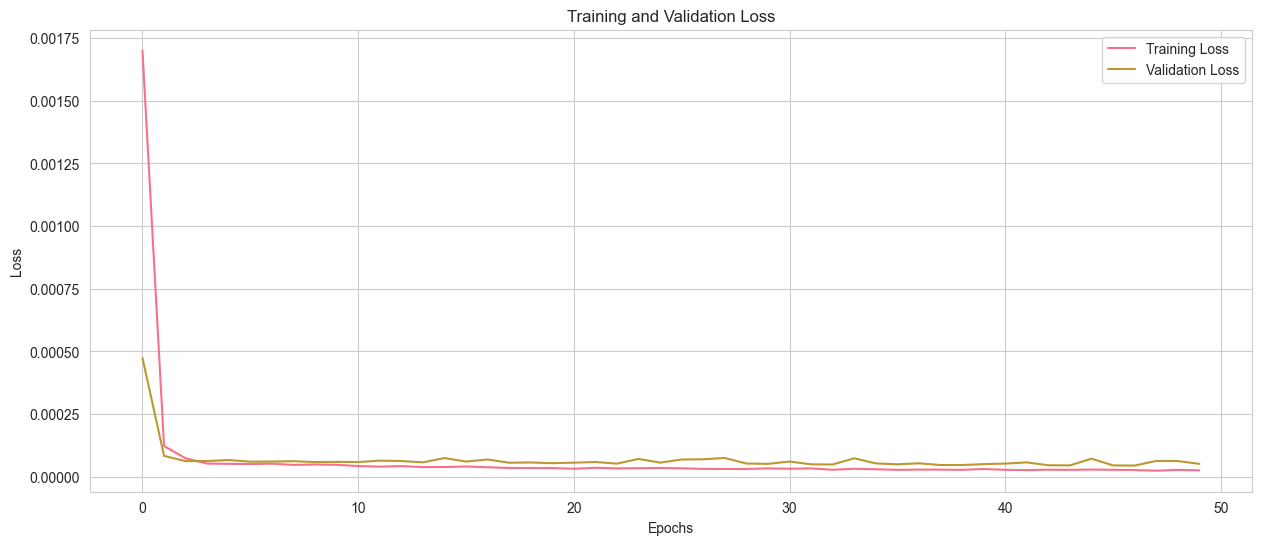

In [121]:
# plot validation loss and training loss

plt.figure(figsize=(15, 6))
sns.set_style('whitegrid')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

In [122]:
# Compute the performance of the model on the testing data set

y_pred = lstm_model.predict(X_test)
lstm_mse = mean_squared_error(y_test, y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test, y_pred)
lstm_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {lstm_mse}")
print(f"Test RMSE: {lstm_rmse}")
print(f"Test MAE: {lstm_mae}")
print(f"Test R2 Score: {lstm_r2}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 0.00047289926152108196
Test RMSE: 0.02174624706750758
Test MAE: 0.01668165954181355
Test R2 Score: 0.989835522959564


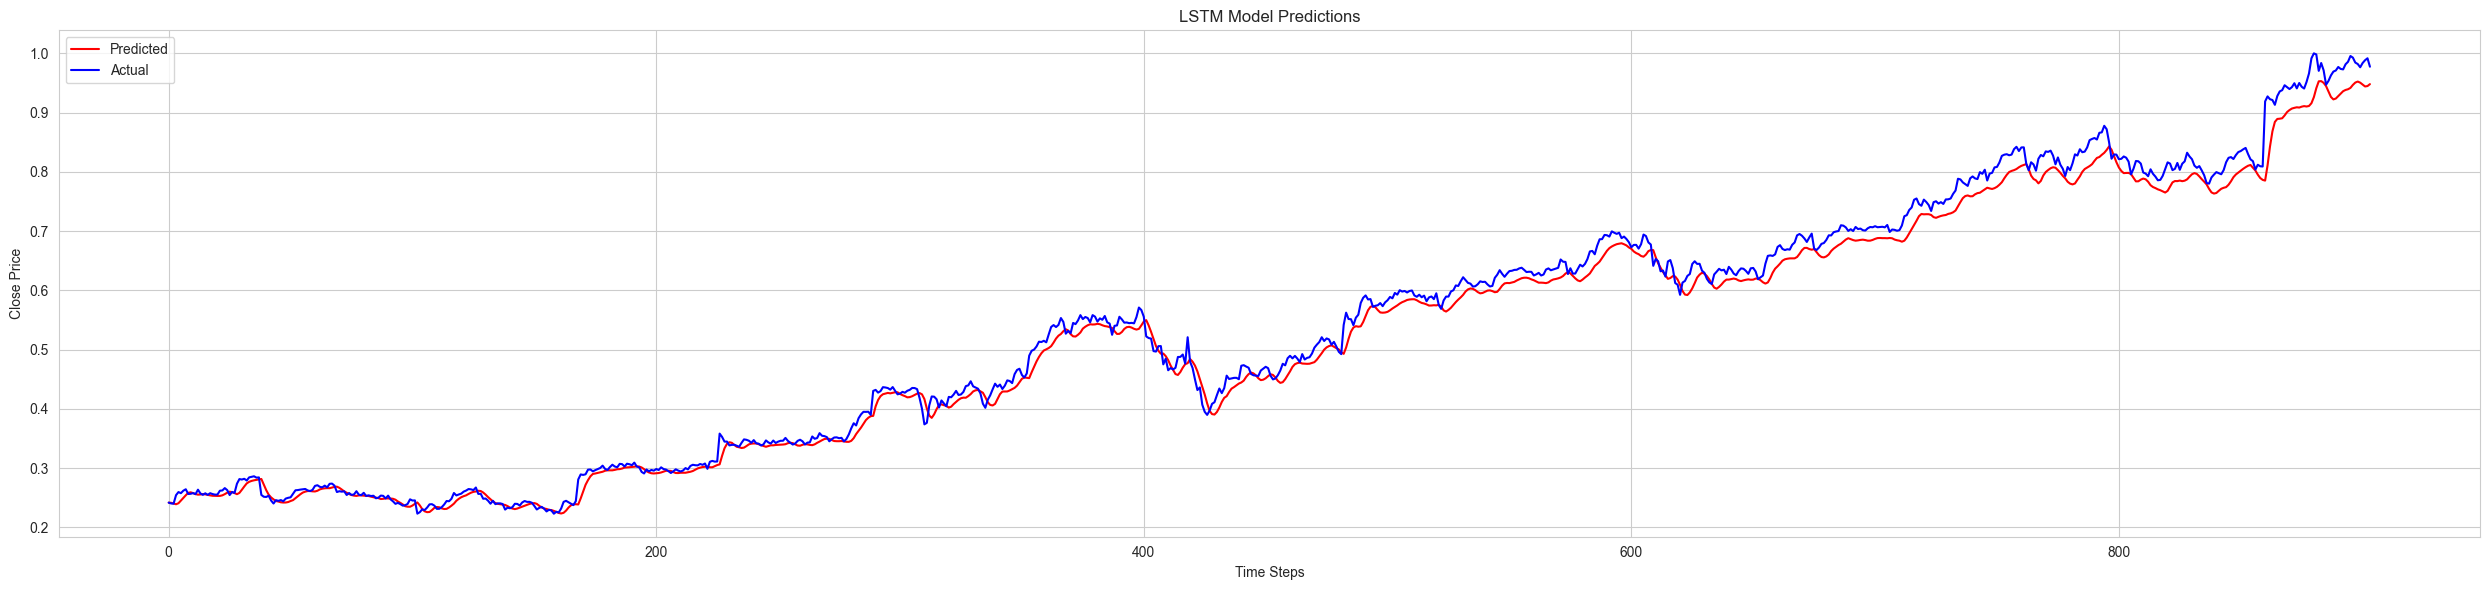

In [123]:
plt.figure(figsize=(25, 6))
sns.set_style('whitegrid')
sns.set_palette('husl')
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred.ravel(), label='Predicted', markers=True, dashes=False, color='red')
sns.lineplot(x=np.arange(len(y_test)), y=y_test.ravel(), label='Actual', markers=True, dashes=False, color='blue')
plt.title('LSTM Model Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
# make a dataframe for predictions

predictions_df['LSTM_Predicted'] = y_pred
predictions_df.head()

,Actual,SRNN_Predicted,LSTM_Predicted
0,0.241733,0.244123,0.241659
1,0.240323,0.243170,0.241452
2,0.239972,0.239419,0.240167
3,0.254326,0.238902,0.238954
4,0.259540,0.243922,0.240689


Plotting the actual vs predicted values

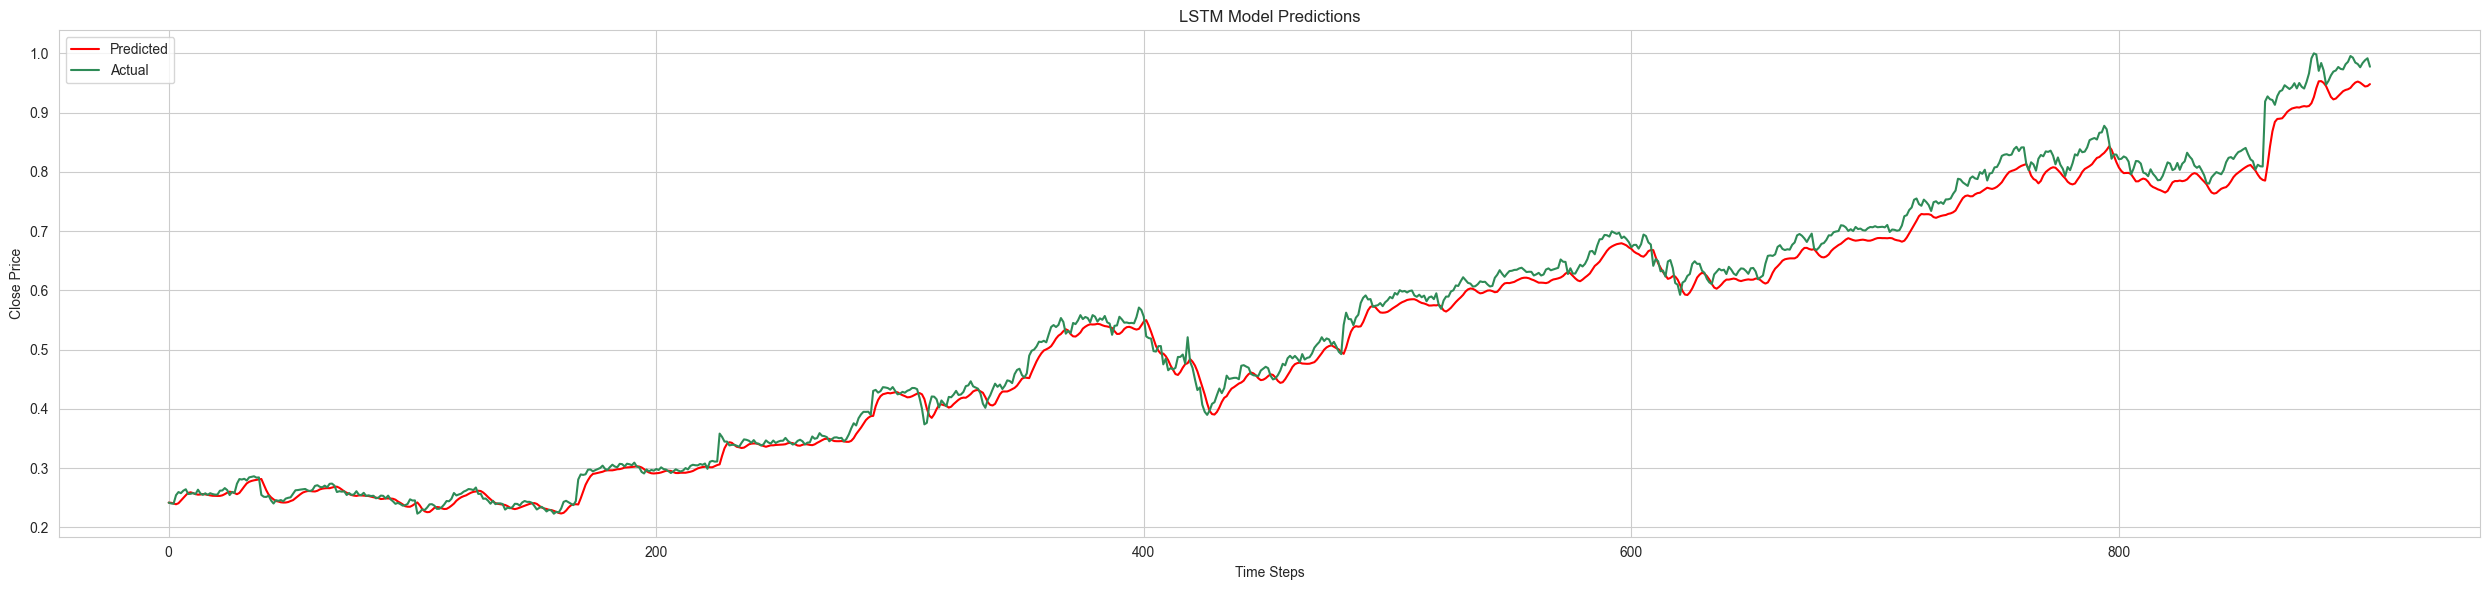

In [125]:
# Predict on the test data

plt.figure(figsize=(25, 6))
sns.set_style('whitegrid')
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred.ravel(), label='Predicted', markers=True, dashes=False, color='red')
sns.lineplot(x=np.arange(len(y_test)), y=y_test.ravel(), label='Actual', markers=True, dashes=False, color='seagreen')
plt.title('LSTM Model Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


In [126]:
# Create a GRU model 

gru_model = create_model((X_train.shape[1], X_train.shape[2]), units, activation, dropout_rate, model_type='GRU')
gru_model.summary()
history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Compute model performance

y_pred = gru_model.predict(X_test)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 150)            │        70,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,801 (276.57 KB)

 Trainable params: 70,801 (276.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0331 - mape: 925.5696 - mse: 0.0022 - r2_score: 0.2782 - val_loss: 8.2005e-05 - val_mae: 0.0075 - val_mape: 3.1461 - val_mse: 8.2005e-05 - val_r2_score: 0.9529
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2227e-05 - mae: 0.0065 - mape: 275.3175 - mse: 9.2227e-05 - r2_score: 0.9699 - val_loss: 1.1000e-04 - val_mae: 0.0083 - val_mape: 3.5899 - val_mse: 1.1000e-04 - val_r2_score: 0.9369
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4574e-05 - mae: 0.0060 - mape: 403.1584 - mse: 7.4574e-05 - r2_score: 0.9757 - val_loss: 5.9045e-05 - val_mae: 0.0057 - val_mape: 2.4411 - val_mse: 5.9045e-05 - val_r2_score: 0.9661
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6939e-05 - mae: 0.0058 - mape: 252.7454 - mse: 6.6939e-05 - r2_score: 0.9782 - val_loss: 1.1690e-04 - val_mae: 0.0087 - val_mape: 3.7661 - val_mse: 1.1690e-04 - val_r2_score: 0.9329
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s

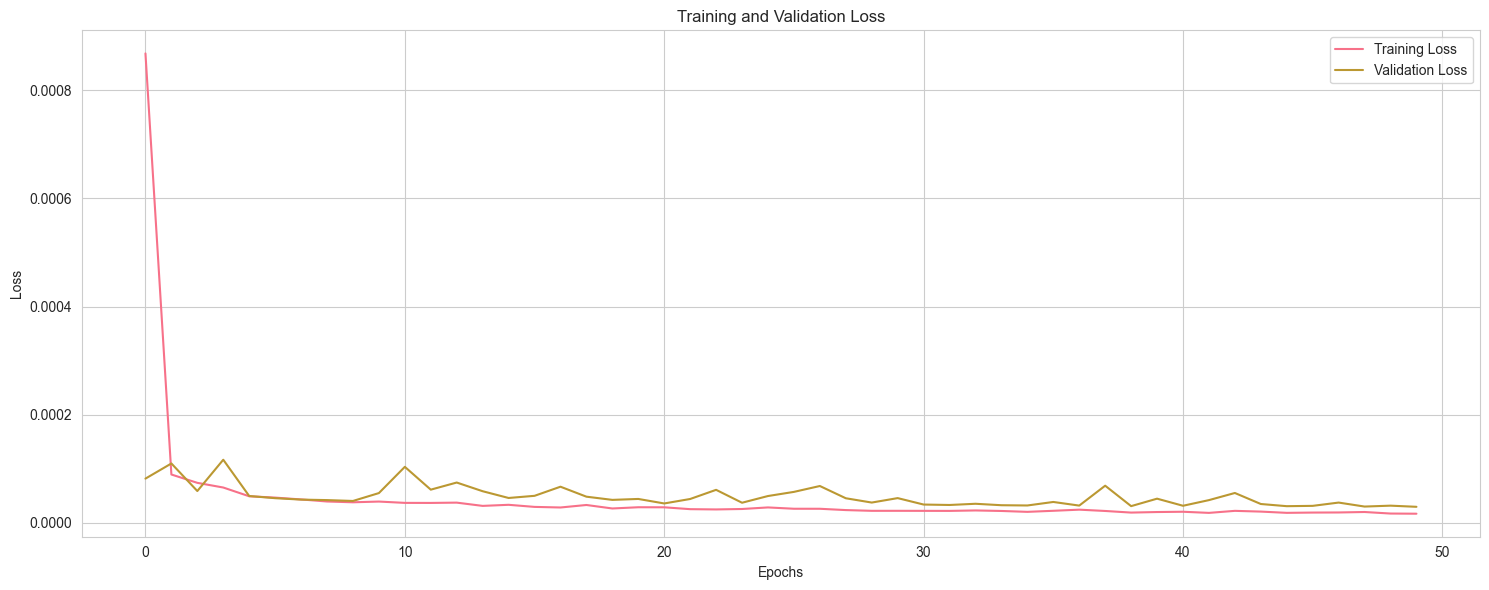

In [127]:
# Plot validation loss and training loss
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()


In [128]:
gru_mse = mean_squared_error(y_test, y_pred)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test, y_pred)
gru_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {gru_mse}")
print(f"Test RMSE: {gru_rmse}")
print(f"Test MAE: {gru_mae}")
print(f"Test R2 Score: {gru_r2}")

Test MSE: 0.00013779941985343427
Test RMSE: 0.011738799762046982
Test MAE: 0.008187246214134166
Test R2 Score: 0.9970381450062316


In [129]:
# Add the predicted values in predictions dataframe

predictions_df['GRU_Predicted'] = y_pred
predictions_df.head()

,Actual,SRNN_Predicted,LSTM_Predicted,GRU_Predicted
0,0.241733,0.244123,0.241659,0.244850
1,0.240323,0.243170,0.241452,0.243308
2,0.239972,0.239419,0.240167,0.240679
3,0.254326,0.238902,0.238954,0.239709
4,0.259540,0.243922,0.240689,0.246685


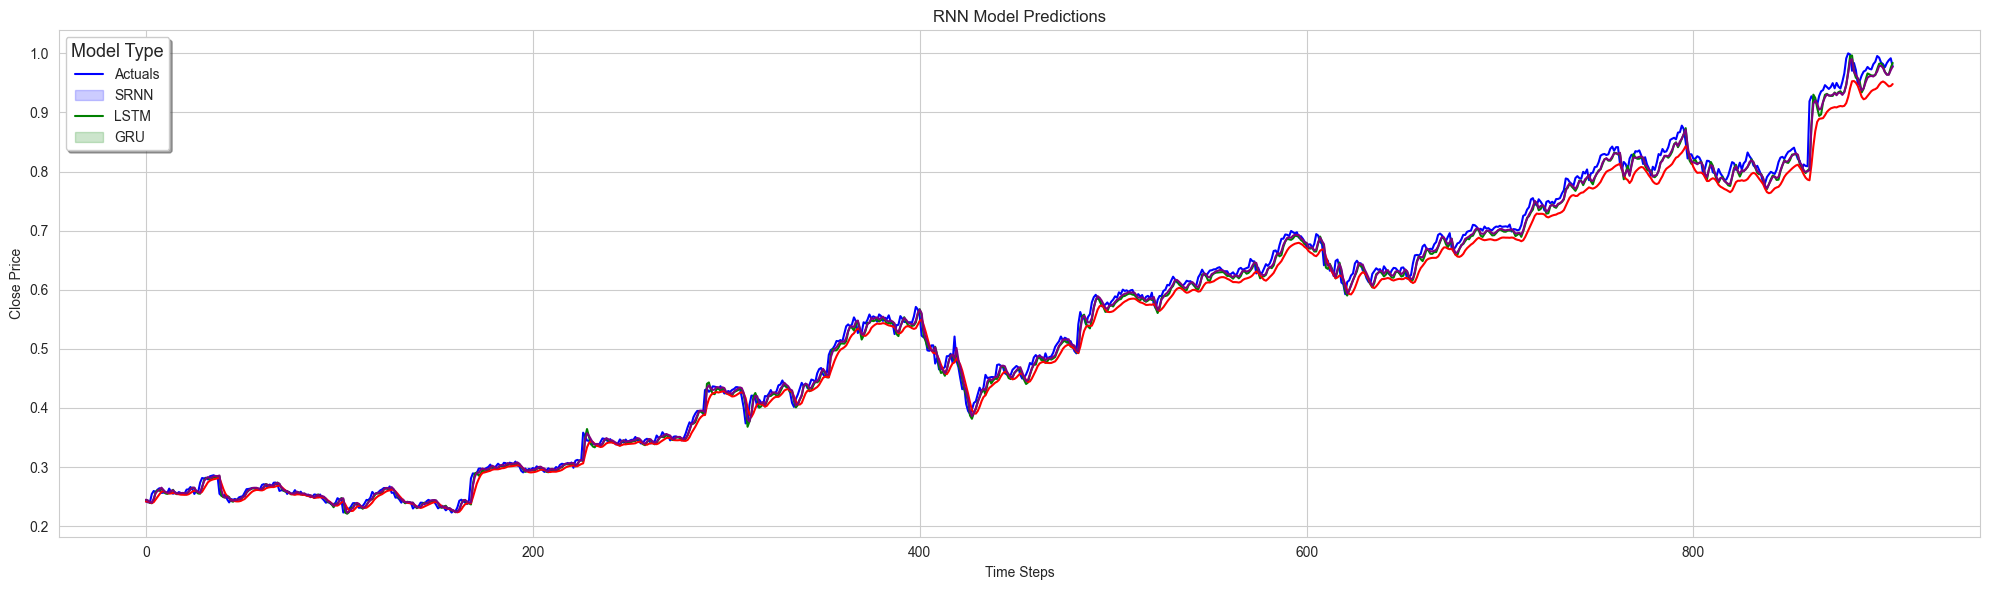

In [130]:
# Plot the predictions
plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
sns.lineplot(x=np.arange(len(y_pred)), y=predictions_df['Actual'], label='Predicted', markers=True, dashes=True, color='blue')
sns.lineplot(x=np.arange(len(y_test)), y=predictions_df['SRNN_Predicted'], label='Actual', markers=True, dashes=False, color='green')
sns.lineplot(x=np.arange(len(y_test)), y=predictions_df['LSTM_Predicted'], label='Actual', markers=True, dashes=False, color='red')
sns.lineplot(x=np.arange(len(y_test)), y=predictions_df['GRU_Predicted'], label='Actual', markers=True, dashes=False, color='purple')
plt.title('RNN Model Predictions')
plt.legend(['Actuals','SRNN', 'LSTM', 'GRU'], loc='upper left', fontsize='medium', title='Model Type', title_fontsize='13', shadow=True)
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.tight_layout()
plt.show()

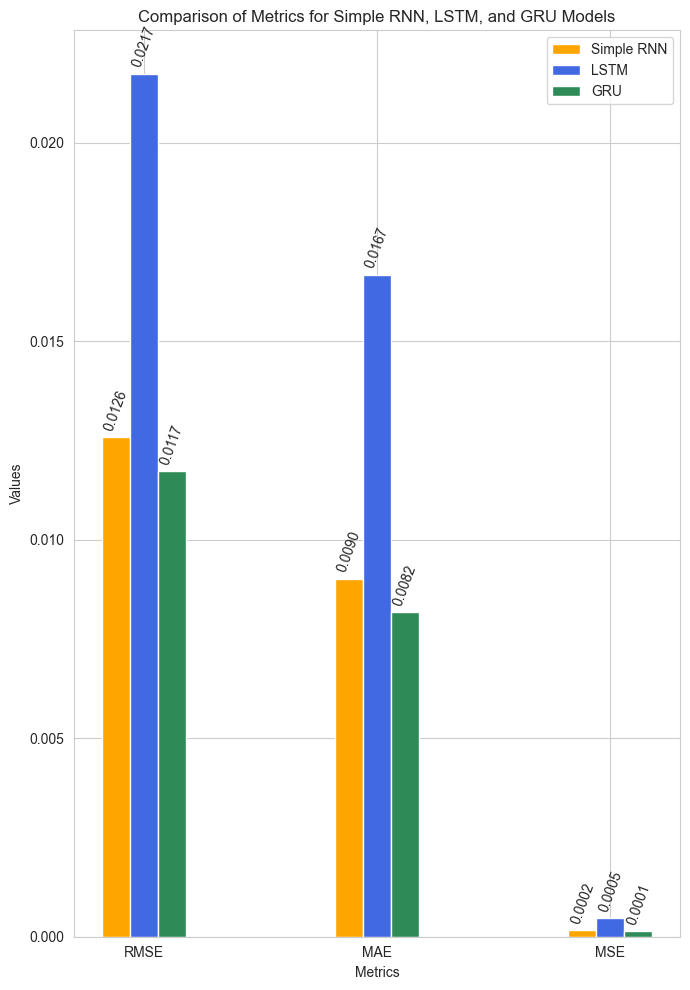

In [147]:
# Compute the performance of the model on the testing data set

# Metrics for Simple RNN and LSTM
metrics = ['RMSE', 'MAE', 'MSE']
simple_rnn_values = [simple_rnn_rmse, simple_rnn_mae, simple_rnn_mse]
lstm_values = [lstm_rmse, lstm_mae, lstm_mse]
gru_values = [gru_rmse, gru_mae, gru_mse]


# Bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.12  # the width of the bars


fig, ax = plt.subplots(figsize=(7, 10))
bars1 = ax.bar(x - width, simple_rnn_values, width, label='Simple RNN', color='orange')
bars2 = ax.bar(x, lstm_values, width, label='LSTM', color='royalblue')
bars3 = ax.bar(x + width, gru_values, width, label='GRU', color='seagreen')

# Add labels, title, and legend

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics for Simple RNN, LSTM, and GRU Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value annotations on top of the bars
for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom',
                rotation=70,
                )

plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [132]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [133]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [134]:
# Find an optimal configuration of simple RNN



In [135]:
# Find the best configuration



In [136]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [137]:
# Compute the performance of the model on the testing data set



In [138]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [139]:
# Find an optimal configuration of advanced RNN



In [140]:
# Find the best configuration



In [141]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [142]:
# Compute the performance of the model on the testing data set



In [143]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.


- Data for stocks of four companies scilicet Amazon, Microsoft, Google and IBM is provided. This data ranges from 3 January 2006 to 29 Dec 2017

- The volume distribution across this duration is similar for all the companies

- Stock volume distribution shows several spikes throughout the period implying that stock trades fluctuations are present. These could probably be due to factors that affect the stock market on the whole

- Features given in the data are highly correlated to each other 

- Models are created using SimpleRNN, LSTM and GRU algorithms. Metrics RMSE, MAE and MSE are depicted in charts and we see that MAE is lowest mostly for GRU model. The metrics values vary with each run. Sample depiction of metrics on different window sizes is shown in the following tables

- ##### Window size: 30, metrics are:

|Model|RMSE|MAE|MSE|
|-----|-----|-----|-----|
|SimpleRNN|0.010471589278261327|0.007178081460653021|0.00010965418201259758|
|LSTM|0.00790157131174701|0.004391336567490916|0.00021806377512260413|
|GRU|0.01476698260047069|0.009856468594265415|0.00021806377512260413|

- ##### Window size: 7, metrics are:

|Model|RMSE|MAE|MSE|
|-----|-----|-----|-----|
|SimpleRNN|0.007306089315403081|0.004314358145900212|5.337894108464707e-05|
|LSTM|0.0076133021086633905|0.004105232263513094|5.7962368997778423e-05|
|GRU|0.008543562396282829|0.00459140935222632|7.299245841917799e-05|


- ##### Window size: 15, metrics are:

|Model|RMSE|MAE|MSE|
|-----|-----|-----|-----|
|SimpleRNN|0.011416393849966618|0.006794768998186914|0.00013033404853755564|
|LSTM|0.010759497711579195|0.006774561816119406|0.00011576679100547792|
|GRU|0.010272094384739857|0.006683314481516841|0.00010551592304900412|

- Predicted values of LSTM and GRU models are very close the actual values
